# Bank Marketing Prediction

## Objectives

The goal is to predict if the client, who received marketing phone calls, will subscribe to a bank service (term deposit). 

Besides developing a classification model to predict if a client will subscribe to the service, I want to analyze how effective was the campaign and what type of client was more likely to subscribe.

I am using the [Bank Marketing Dataset](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) from the UCI Machine Learning Repository

In [1]:
#Imports

# Data munging and exploration
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Data pre-processing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from sklearn.feature_selection import RFECV, RFE, mutual_info_classif

#Modeling
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

#Metrics
from sklearn.metrics import accuracy_score

#Hiding warnings
import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
#Loading train dataset
bank=pd.read_csv('bank-full.csv',  sep=';')

In [3]:
# Checking the dataset

print("\n Bank dataset dimensions", bank.shape)
print("\n Columns info", bank.info())


 Bank dataset dimensions (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

 Columns info None


In [4]:
#Taking a look at the dataset
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Feature Engineering & Exploration

<strong> y: target variable - </strong> Has the client subscribed to a term deposit? yes/no

In [5]:
#Checking how many customers have subscribed to the service
bank.groupby('y').size()

y
no     39922
yes     5289
dtype: int64

There are two things that I'll have to work on here. First, I'll have to recode 'yes' and 'no' to numbers because the algorithms won't read the way it is now. Also, the categories are pretty unbalanced. I'll have to balance the dataset before modelling, but I'll do it later in the notebook.  

In [6]:
#Taking a look at the proportion of the categories
no_sub= len(bank[bank['y']=='no'])
do_sub= len(bank[bank['y']=='yes'])
pc_sub= do_sub/(do_sub + no_sub)
print("share of clients subscribing to the service:", round(pc_sub*100, 2))
pc_no_sub= no_sub/(do_sub + no_sub)
print("share of clients not subscribing to the service:", round(pc_no_sub*100, 2))

share of clients subscribing to the service: 11.7
share of clients not subscribing to the service: 88.3


In [7]:
#Changing labels

#creating a dictionary to change labels:
y_labels={"y":{"yes":1,"no":0}}

#changing the columns in the dataset and taking a look
bank.replace(y_labels, inplace=True)

<strong> Client data </strong>

<strong> Age </strong>

In [8]:
##Defining function to create histograms
def hist_graph(data,column):
    sns.histplot(data=data, x=column, color='teal')

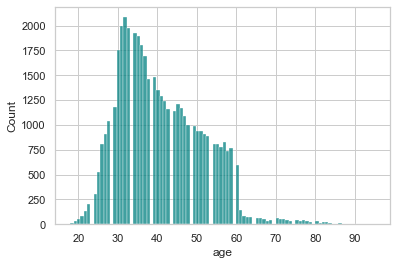

In [9]:
#checking the distribution of the variable
hist_graph(bank,'age')

Most clients are between 30-40 and 40-50 years of age. How about those who subscribed to the service?

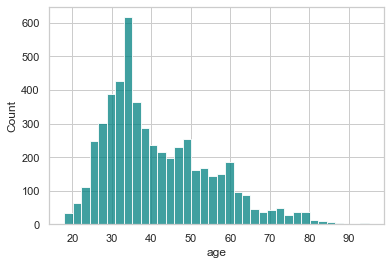

In [10]:
#distribution when y=1
bank_y=bank[bank['y']==1]
hist_graph(bank_y,'age')

They are mostly on their late 20s and between 30-40 years of age

<strong> Balance </strong>

In [11]:
bank['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [12]:
bank_y['balance'].describe()

count     5289.000000
mean      1804.267915
std       3501.104777
min      -3058.000000
25%        210.000000
50%        733.000000
75%       2159.000000
max      81204.000000
Name: balance, dtype: float64

<strong> Job </strong>

In [13]:
#Defining function to create count graphs
def count_graph(data,column):
    sns.catplot(y=column, data=data, kind="count", color='darkturquoise',
           order = data[column].value_counts().index)

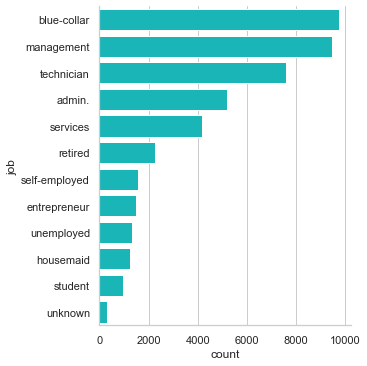

In [14]:
#Count
count_graph(bank,'job')

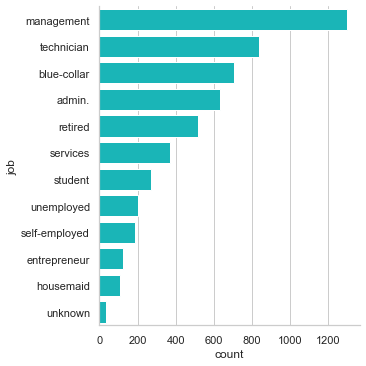

In [15]:
# Count of clients who got the service
count_graph(bank_y,'job')

It's interesting to see that despite having more blue-collar workers in the dataset, managers and technicians are the ones who subscribe more to the service.

<strong> Marital </strong>

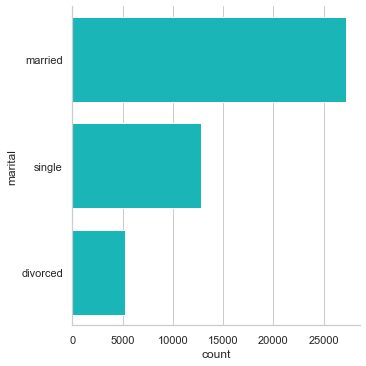

In [16]:
count_graph(bank,'marital')

<strong> Education </strong>

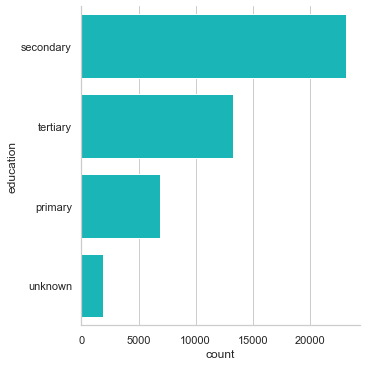

In [17]:
count_graph(bank,'education')

Most clients in the dataset are married and has secondary education (which was expected since most of them are blue-collars)

In [18]:
#One-hot enconding variables job, marital and education
bank=pd.get_dummies(bank,columns=['job','marital','education'])

<strong> Default: </strong> has credit in default?

In [19]:
#Defining function to automate group_by and count values
def group_count(data,column):
    print(data.groupby(column).size())

In [20]:
group_count(bank,'default')

default
no     44396
yes      815
dtype: int64


In [21]:
#did clients who got the service have credit in default?
group_count(bank_y,'default')

default
no     5237
yes      52
dtype: int64


<strong> Housing </strong>

In [22]:
group_count(bank,'housing')

housing
no     20081
yes    25130
dtype: int64


In [23]:
#did clients who got the service have a house?
group_count(bank_y,'housing')

housing
no     3354
yes    1935
dtype: int64


<strong> Loan </strong>

In [24]:
group_count(bank,'loan')

loan
no     37967
yes     7244
dtype: int64


In [25]:
#did clients who got the service have a loan?
group_count(bank_y,'loan')

loan
no     4805
yes     484
dtype: int64


Most clients who subscribed to the service do not have a house, differently from the overall pattern found in the whole dataset. 

In [26]:
#One-hot enconding variables job, marital and education
bank=pd.get_dummies(bank,columns=['default','housing','loan'])

<strong> Data about the last contact of the current campaign </strong>

<strong> contact: </strong> contact communication type (categorical: 'cellular','telephone') 

In [27]:
group_count(bank,'contact')

contact
cellular     29285
telephone     2906
unknown      13020
dtype: int64


<strong> day: </strong> day of the month

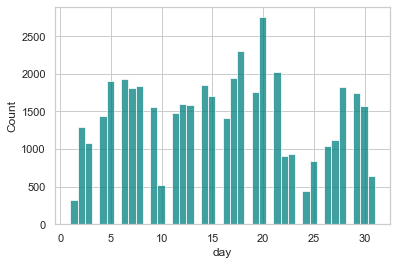

In [28]:
hist_graph(bank,'day')

day
1      90
2     182
3     178
4     230
5     215
6     181
7     157
8     201
9     179
10    121
11    181
12    244
13    241
14    210
15    238
16    192
17    176
18    228
19    122
20    192
21    201
22    154
23    126
24     62
25    133
26    116
27    150
28    143
29    129
30    271
31     46
dtype: int64
None


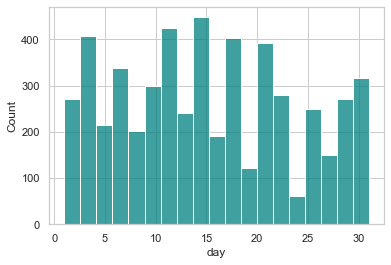

In [29]:
print(group_count(bank_y,'day'))
hist_graph(bank_y,'day')

<strong> month </strong>

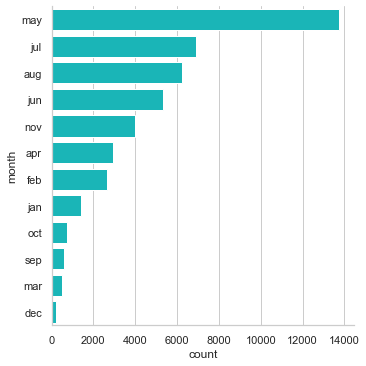

In [30]:
count_graph(bank,'month')

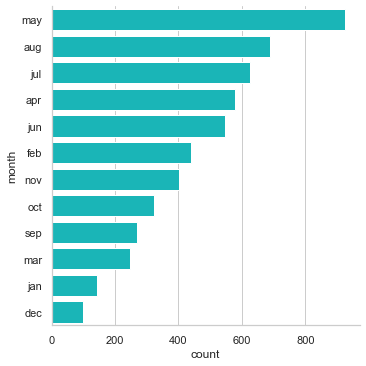

In [31]:
count_graph(bank_y,'month')

I don't see any interesting patterns in the days feature, but it seems that most of the calls were made in between may and august.

In [32]:
#One-hot encoding contact, day and month
bank=pd.get_dummies(bank,columns=['contact','day','month'])

<strong> duration: </strong> past contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

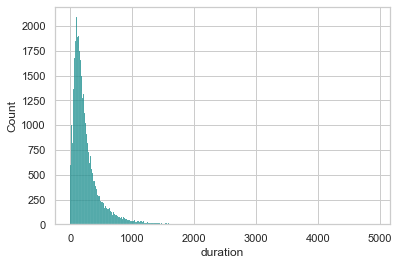

In [33]:
hist_graph(bank,'duration')

In [34]:
bank['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [35]:
bank_y['duration'].describe()

count    5289.000000
mean      537.294574
std       392.525262
min         8.000000
25%       244.000000
50%       426.000000
75%       725.000000
max      3881.000000
Name: duration, dtype: float64

In [36]:
len(bank[bank['duration'] == 0])

3

There are only 3 zero cases so I don't believe y is so affected by this cases. However, since I wanna develop a predictive model I won't be able to use this feature since it is not possible to now how long the call will be before hand, which will be impossible to make a prediction about new calls. In this sense, I'll drop this feature.

In [37]:
del bank['duration']

<strong> Data related to the campaign </strong>

<strong> Campaign: </strong> number of contacts performed during the campaign for this client

In [38]:
bank['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

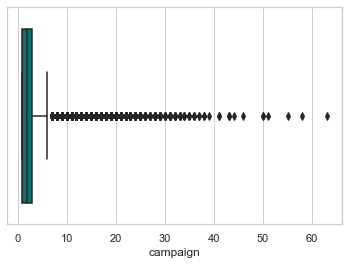

In [39]:
#Distribution of the campaign variable
sns.boxplot(x=bank['campaign'], color='teal')

count    5289.000000
mean        2.141047
std         1.921826
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: campaign, dtype: float64


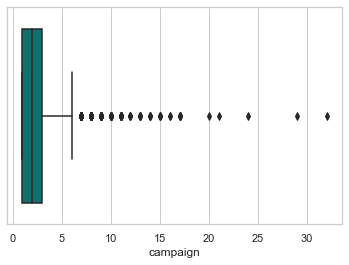

In [40]:
#Distribution of the campaign variable only for clients who got the 
#service
print(bank_y['campaign'].describe())
sns.boxplot(x=bank_y['campaign'], color='teal')

In [41]:
print('Length of the dataset:', len(bank))
print('How many clients got more than 5 calls:',len(bank[bank['campaign']>5]))
print('Proportion of clients who got more than 5 calls:',round(len(bank[bank['campaign']>5])/len(bank)*100),'%')

Length of the dataset: 45211
How many clients got more than 5 calls: 4355
Proportion of clients who got more than 5 calls: 10 %


Each client got around 2 to 3 calls on average on the whole dataset and among those who got the service. However, around 10% of the clients got more than 5 calls. It is a lot of calls and it may bother the clients to get so many of them. Let's see how many clients who got more than 5 calls subscribed to the service:

In [42]:
print("Proportion of clients who subscribed to the service and got more than 5 calls:",
round(len(bank_y[bank_y['campaign']>5])/len(bank_y)*100),'%')

print('Absolute number of clients who subscribed and received 5 calls:',len(bank_y[bank_y['campaign']>5]))

Proportion of clients who subscribed to the service and got more than 5 calls: 5 %
Absolute number of clients who subscribed and received 5 calls: 253


Only 5% of the clients who subscribed to the service received more than 5 calls. Only 253 clients that received more than five calls got the service in a total of 45211 clients. This is less than 1% of the dataset. It seems like a loss of time and resources just to get a few more clients that could be used in another strategy (like getting more clients and offer them this service, for example)

<strong> pdays: </strong> number of days that passed by after the client was last contacted from a previous campaign 

In [43]:
print('Head',bank.groupby('pdays').size().head())
print('Tail',bank.groupby('pdays').size().tail())

Head pdays
-1    36954
 1       15
 2       37
 3        1
 4        2
dtype: int64
Tail pdays
838    1
842    1
850    1
854    1
871    1
dtype: int64


It is weird that most of the cases has -1 as value. The data dictionary does not have any information about this value. It just says that if a client was not contacted it received the value 999, but there is no case with this value.

In [44]:
print('Proportion of clients that were assigned -1 in pdays',round(36954/45211*100,2),'%')

Proportion of clients that were assigned -1 in pdays 81.74 %


There is not much I can do with this feature since I don't have more information about it. Since there is almost no variation in it probably it will be dropped during feature selection. So I will not do any changes on it.

<strong> previous: </strong> number of contacts performed before this campaign and for this client (numeric)

In [45]:
group_count(bank,'previous')

previous
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
14        19
15        20
16        13
17        15
18         6
19        11
20         8
21         4
22         6
23         8
24         5
25         4
26         2
27         5
28         2
29         4
30         3
32         1
35         1
37         2
38         2
40         1
41         1
51         1
55         1
58         1
275        1
dtype: int64


The number of zeros are the same of -1 in the pdays feature. This means that -1 in pdays is the same as zero days that passed after the client was contacted. I say it is zero days because actually the clients were never contacted. I can create another variable based on these two that will tell me if the client was ever contacted before. Before that I should check the outcome varible to see if it gives me this information (if there was a campaign call with the client or not)

<strong> poutcome: </strong> outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [46]:
group_count(bank,'poutcome')

poutcome
failure     4901
other       1840
success     1511
unknown    36959
dtype: int64


In [47]:
##One-hot encoding poutcome
bank=pd.get_dummies(bank,columns=['poutcome'])

It seems that this more than 36.000 cases are clients that were not targeted on previous campaigns. I'll take a closer look on these cases.

In [48]:
#Creating a dataset with only pdays== -1
df_pdays=bank[bank['pdays']==-1]
print(len(df_pdays))

36954


In [49]:
group_count(df_pdays,'previous')

previous
0    36954
dtype: int64


In [50]:
df_pdays['campaign'].describe()

count    36954.000000
mean         2.921957
std          3.325791
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

Like I've imagined, pdays and previous presents values -1 and 0 for clients that were not contacted on previous campaigns and this was a huge amount (81%) of all clients. However they were contacted on this new campaign.

In [51]:
#Checking the correlation between pdays and previous
prev=['pdays','previous']
corr = bank[prev].corr()
corr

,pdays,previous
pdays,1.00000,0.45482
previous,0.45482,1.00000


In [52]:
#Replacing -1 to zero on pdays
bank['pdays']=bank['pdays'].replace(-1,0)

There's some correlation but I don't think it is too high. I'll keep both features

<strong> Scaling data </strong>

In [53]:
#List with numeric features
num=['age','balance', 'campaign','pdays','previous']

In [54]:
#Scaling numeric features. I'll use MinMaxScaler so the variables will
# be between 0 and 1
scaler = MinMaxScaler() 

bank[num]= pd.DataFrame(scaler.fit_transform(bank[num]))

**Splitting data into train and test**

In [55]:
#Separating X and y 

X=bank.loc[:, bank.columns != 'y']
y=bank['y']

In [56]:
#Splitting

X_train, X_test, y_train, y_test= train_test_split(
    X,y, test_size=0.3, random_state=42)

<strong> Balancing the training dataset </strong>

In [57]:
print('Original dataset shape %s' % y_train.value_counts())

Original dataset shape 0    27956
1     3691
Name: y, dtype: int64


In [58]:
#Creating the smote object. I'll up-sample the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [59]:
#Resampling
X_train, y_train = sm.fit_resample(X_train, y_train)

In [60]:
#Checking
print('Resampled dataset shape %s' % y_train.value_counts())

Resampled dataset shape 1    27956
0    27956
Name: y, dtype: int64


## Feature Selection

I'll do a Recursive Feature Elimination with cross-validation to find the optimal number of features for modeling. I'll run it with a decision tree estimator.

In [61]:
# Create the RFE object and compute a cross-validated score.

#Estimator will be a decision tree
est = DecisionTreeClassifier(random_state=0)

# Minimum number of features to consider
min_features_to_select = 1  

rfecv = RFECV(est, step=1, cv=RepeatedKFold(n_splits=3, n_repeats=2,random_state=0),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)


print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 79


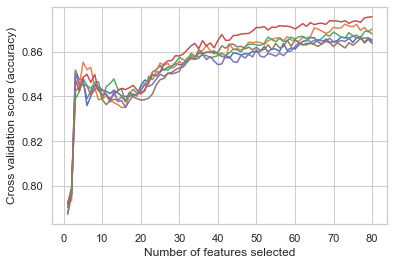

In [62]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (accuracy)')
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [63]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(15, 60,5):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [64]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s features %.3f (%.3f)' % (name, mean(scores), std(scores)))


>15 features 0.840 (0.003)
>20 features 0.842 (0.002)
>25 features 0.850 (0.002)
>30 features 0.854 (0.002)
>35 features 0.859 (0.002)
>40 features 0.861 (0.003)
>45 features 0.861 (0.004)
>50 features 0.864 (0.003)
>55 features 0.864 (0.004)


The RFECV determines that 79 would be the optimal number of features to obtain the best accuracy score. However, it is a high number of predictors and overfitting could probably occur. I'll run a mutual information feature selection to verify the group of features that contibutes more for the correct prediction of the target variable

In [65]:
# Creating mutual_info_classif object.

bestMI = mutual_info_classif(X_train, y_train, discrete_features = 'auto', n_neighbors = 3)

#Saving scores in a pandas series.

bestMI_scores = pd.Series(bestMI, index = X_train.columns)

#Saving in decreasing order.
bestMI_scores = bestMI_scores.sort_values(ascending = False)

In [66]:
#Selecting features that the score were not zero
bestMI_scores=bestMI_scores[bestMI_scores.values>=0.005]

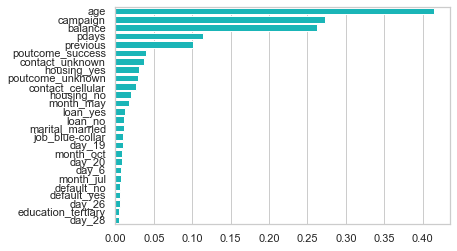

In [67]:
#Plotting Mutual Information scores
sns.barplot(bestMI_scores.values, bestMI_scores.index, color='darkturquoise')

In [68]:
#How many features were selected?
len(bestMI_scores)

26

In [69]:
#Collecting features selected by MI
X_MI=X_train[bestMI_scores.index]

In [70]:
#Results of RFE for 23 features

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=23)
rfe.fit(X_train,y_train)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=23)

In [71]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 35.000
Column: 8, Selected False, Rank: 54.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 41.000
Column: 11, Selected False, Rank: 22.000
Column: 12, Selected False, Rank: 4.000
Column: 13, Selected False, Rank: 31.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 40.000
Column: 16, Selected False, Rank: 58.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 24.000
Column: 24, Selected False, Rank: 37.000
Column: 25, Sele

In [72]:
# Collecting features selected by RFE
feat=X_train.columns[rfe.support_]
X_rfe = X_train[feat]

## Predictive Modeling

I'll define a function to run different algorithms in order to identify the one that performs best (has best accuracy score). I'll evaluate them through cross-validation

In [73]:
def classifiers(X, y, printMeans = True, scoring = 'accuracy'):
    
    # Setting seed and number of folds.
    
    folds = 10

    # List to save models.

    models = []

    # Lists to save results and the names of the algorithms.

    results = []
    names   = []

    # Dataframe to save means and standard deviations.

    means   = pd.DataFrame(columns = ['mean', 'std'])

    #Appending models to the models list. I'm running algorithms 
    #with their default hyperparemeters.

    models.append(('Logistic Regression', LogisticRegression()))
    models.append(('Naive Bayes', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Gradient Boosting', GradientBoostingClassifier()))
    models.append(('Random Forest', RandomForestClassifier()))

    # Evaluation

    for name, model in models:
        
        # Kfold object.

        kfold = KFold(n_splits = folds)
        
        # Cross Validation.

        cv_results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)
        
        # Appending results to results list.

        results.append(cv_results)
        
        # Appending algorithm names to names list.

        names.append(name)

        # Saving means and standard deviations to means dataframe

        means = means.append (
            pd.DataFrame (
                data    = [[cv_results.mean(), cv_results.std()]], 
                columns = ['mean', 'std'], 
                index   = [name]
            )
        )

        # Printing results (default is 'True')
        
        if printMeans:
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

    # Dataframe with results

    results = pd.DataFrame(np.transpose(results), columns = names)

    # Return dataframe
    return (results, means)

In [74]:
## Evaluating algorithms with features selected by RFE

check_rfe=classifiers(X=X_rfe, y=y_train)

Logistic Regression: 0.695700 (0.029492)
Naive Bayes: 0.691264 (0.039551)
KNN: 0.785254 (0.055832)
CART: 0.849605 (0.052275)
AdaBoost: 0.783624 (0.014317)
Gradient Boosting: 0.839784 (0.016589)
Random Forest: 0.894353 (0.028710)


In [75]:
## Evaluating algorithms with features selected by MI
check_mi=classifiers(X=X_MI, y=y_train)

Logistic Regression: 0.682197 (0.015771)
Naive Bayes: 0.674510 (0.102631)
KNN: 0.766438 (0.043879)
CART: 0.847548 (0.052442)
AdaBoost: 0.790117 (0.013061)
Gradient Boosting: 0.839980 (0.015247)
Random Forest: 0.883174 (0.025735)


I'll use the features selected by the RFE because they presented slightly better accuracy scores. 

Now I'll train and test the Random Forest, that delivered the best performance, with the default hyperparameters to verify if there's overfitting.

In [76]:
# Preparing features for testing
X_rfe_test=X_test[feat]

In [77]:
# Object with the selected model
rf=RandomForestClassifier()

In [78]:
#Training and Testing
model1=rf.fit(X_rfe,y_train)

In [79]:
#Train result
model1_train_result=model1.score(X_rfe,y_train)

print("Accuracy on training: %.3f%%" % (model1_train_result * 100.0))

Accuracy on training: 99.987%


In [80]:
#Test results
model1_pred=model1.predict(X_rfe_test)

model1_test_result=accuracy_score(y_test,model1_pred)

print("Accuracy on test: %.3f%%" % (model1_test_result * 100.0))

Accuracy on test: 84.813%


**OVERFITTING!**

**Next:** 
1. Create confusion matrix
2. There's overfitting! Come back to feature selection to reduce the number of features
3. Grid Search for best hyperparemeters. 